# ANALYSIS OF MTOR

This notebook contains an analysis of the mTOR system described in a paper by TM Varusai and LK Nguyen, 2018
(Dynamic modelling of the mTOR signalling network reveals complex emergent behaviours conferred by DEPTOR. 
Varusai TM, Nguyen LK
Scientific reports , 1/ 2018 , Volume 8 , Issue 1 , pages: 643 , PubMed ID: 29330362). The SBML model for this system is in Biomodels, ``BIOMD0000000823``.

We consider a model of the signaling network for mTOR, the mechanistic Target of Rapamycin (mTOR), an evolutionarily conserved network that controls key cellular processes, especially cell growth and metabolism. The signalling cascade is activated by a variety of receptor tyrosine kinases, most notably the Insulin Receptor.

<img src="images/mTOR-System.png"
     alt="Markdown Monster icon" 
     width="500" height="600"
     style="float: left; margin-right: 10px;" />

In [1]:
from controlSBML import ControlSBML

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Problem Statement

The biological problem we address is controlling the concentration of phosphorylated ``mTORC1``, ``pmTORC1`. This system has complex dynamics, with both oscillations and bistatility. We want to operate in a region that avoids both. Our control objectives are:
* Regulate ``pmTORC1` to a setpoint
* Fast settling times
* Avoid oscillations

# System Definition

A system is defined by its inputs, outputs, and operating point. The latter refers to the range of inputs over which the system operates. We have specified the output in our problem statement. We need to find an input that regulates ``pmTORC1`` to a setpoint. Further, we need to determine the range of inputs values over which the closed loop system operates since the system behavior may depend on these ranges.

Here is a plot of the floating species.

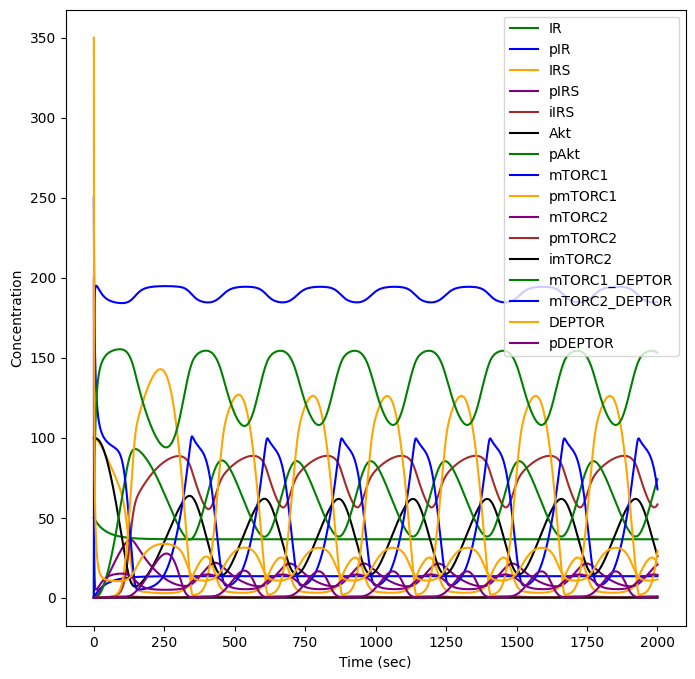

In [4]:
_ = CTLSB.plotModel(figsize=(8,8))

We begin by selecting an input. The possible inputs can be determined by creating a ``ControlSBML`` object for the model, and listing candidate inputs.

In [2]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1909250003/2/Varusai2018.xml"
ctlsb = ControlSBML(URL)
print(ctlsb.getPossibleInputs())

floating_species:	IR, pIR, IRS, pIRS, iIRS, Akt, pAkt, mTORC1, pmTORC1, mTORC2, pmTORC2, imTORC2, mTORC1_DEPTOR, mTORC2_DEPTOR, DEPTOR, pDEPTOR

parameter:	V1, Km1, V2, Km2, k3c, Km3, V4, Km4, k5ca, Km5a, k5cb, Km5b, V6, Km6, k7c, Km7, V8, Km8, k9c, Km9, V10, Km10, k11ca, Km11a, k11cb, Km11b, V12, Km12, k13f, k13r, k14f, k14r, k15c, Km15, V16, Km16, ks17, kd18


Based on this, we decide to try the phosphorylated insulin receptor, ``pIRS``.

In [26]:
INPUT_NAME = "pIRS"
OUTPUT_NAME = "pmTORC1"
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1909250003/2/Varusai2018.xml"
CTLSB = ControlSBML(URL, figsize=(5, 5), times=np.linspace(0, 2000, 20000), markers=False,
                   save_path="data.csv", input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])  # Specify default value of options

We can look at just a subset of the floating specifies by using the output of ``plotModel``.

<Axes: xlabel='miliseconds'>

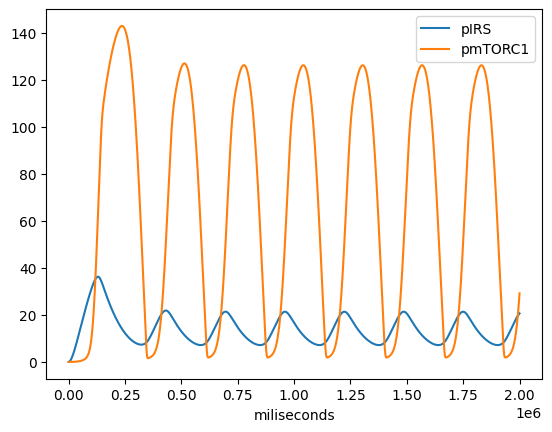

In [5]:
ts = CTLSB.plotModel(is_plot=False)
df = ts[[INPUT_NAME, OUTPUT_NAME]]
seconds = np.array(df.index)/1000
df.index = seconds
df.plot()

The input and output seem to be related. The question is can we *control* the output by varying the input? To anser this question, we construct a *staircase plot*. This plot sets the input to values that are changed during the simulation. We want to see if the output tracks these changes in input.

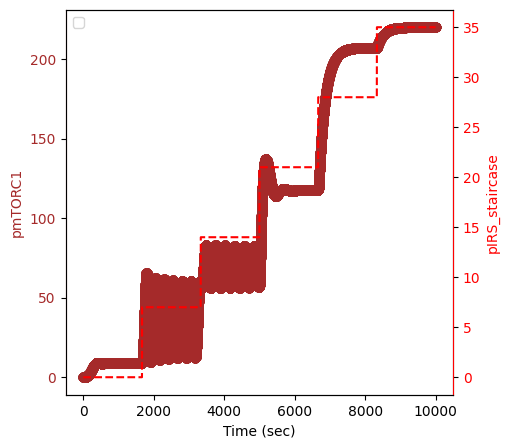

In [6]:
_ = CTLSB.plotStaircaseResponse(initial_value=0, final_value=35, times=np.linspace(0, 10000, 100000))

Clearly, the effect of theinput, pIRS, is effective over only a subset of the range of pIRS. So, we narrow the operating region to interval [20, 25].

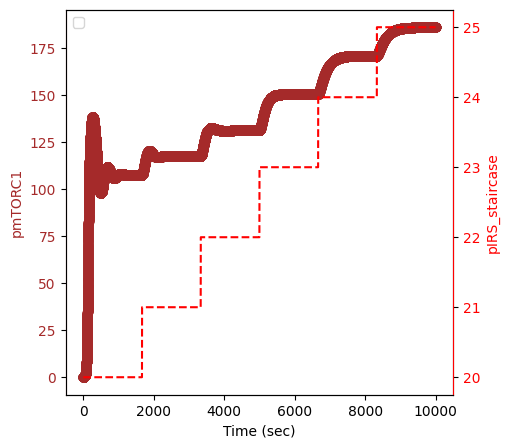

In [7]:
_, builder = CTLSB.plotStaircaseResponse(initial_value=20, final_value=25, times=np.linspace(0, 10000, 100000))

The variable ``builder`` is an ``AntimonyBuilder`` object. ``ControlSBML`` operates by modifying the Antimony source code, and this is done by ``AntimonyBuilder``. Typing the name of the variable produces the Antimony code that is produced. These can be found towards the end, as indicated by the comment lines.

In [8]:
builder

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in c

* The system is controllable in the region V1 $>4$, although the control decreases with larger V1 for both complexes.
* The operating region for V1 implies an operating region for pmTORC1 of 180 to 220 and for pmTORC2 0.7 to 1.0.

# System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``pIRS`` and the output is ``pmTORC1``. ``pIRS`` is varied over the operating region of [29, 25]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit. It returns a Timeseries (a dataframe with the data plotted) and an AntimonyBuilder (the Antimony code run to produce the fitting data).

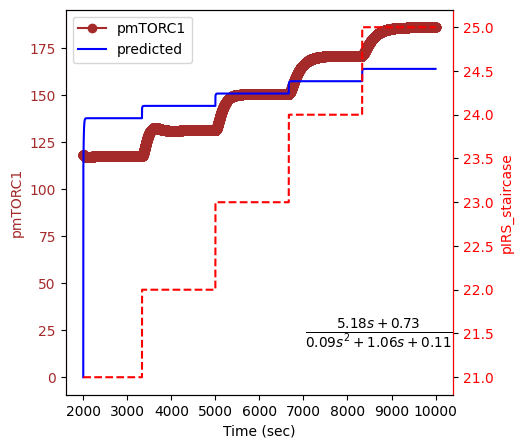

In [28]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=2, num_denominator=3, initial_value=20, final_value=25,
                                  fit_start_time=2000, times=np.linspace(0, 10000, 100000))

We can obtain the transfer function object.

In [30]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

TransferFunction(array([5.17540964, 0.72799145]), array([0.08670629, 1.05595003, 0.11112446]))

In [31]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([-12.07230933+0.j,  -0.10616191+0.j]), array([-0.14066354+0.j]))

The very small value of the second pole suggests that we might be able to approximate this system with a one pole model.

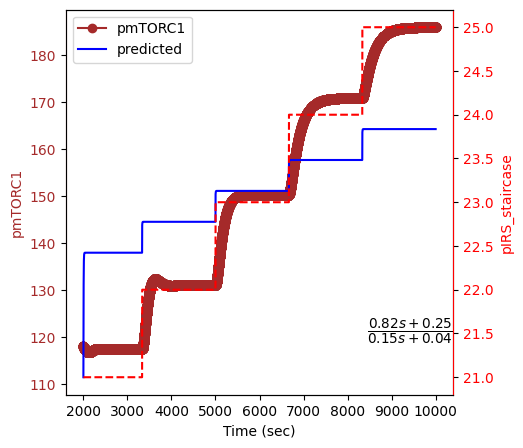

In [32]:
_ = CTLSB.plotTransferFunctionFit(num_numerator=2, num_denominator=2, initial_value=20, final_value=25,
                                  fit_start_time=2000, times=np.linspace(0, 10000, 100000))

In [34]:
CTLSB.getOpenLoopTransferFunction()

TransferFunction(array([0.82216096, 0.2519272 ]), array([0.15485151, 0.03834585]))

In [33]:
tf = CTLSB.getOpenLoopTransferFunction()
tf.poles(), tf.zeros()

(array([-0.24762984+0.j]), array([-0.30642078+0.j]))

The fit is not nearly as good, and the poles and zeroes have much different values. So, we stick with the second order model.

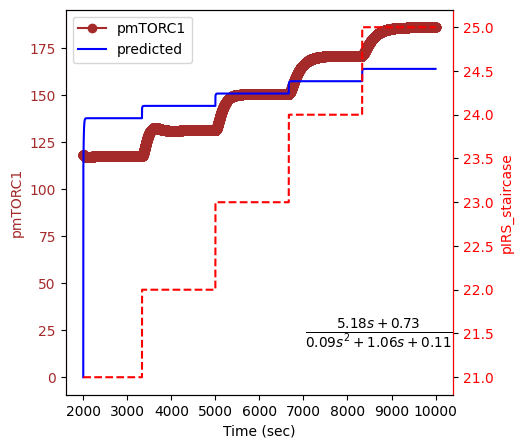

In [36]:
# Recover the previous transfer function
_ = CTLSB.plotTransferFunctionFit(num_numerator=2, num_denominator=3, initial_value=20, final_value=25,
                                  fit_start_time=2000, times=np.linspace(0, 10000, 100000))

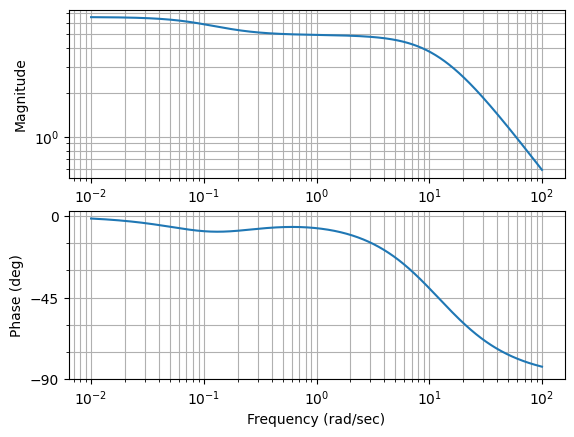

In [37]:
_ = control.bode(TRANSFER_FUNCTION)

In [38]:
TRANSFER_FUNCTION.bandwidth()

4.468340761707099

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

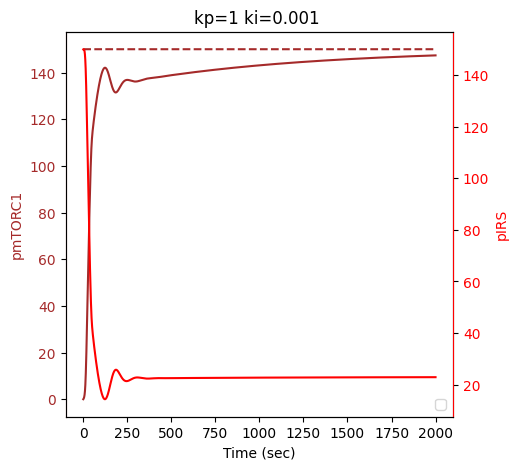

In [14]:
_, builder = CTLSB.plotClosedLoop(setpoint=150, kp=1, ki=0.001, kf=None)

In [15]:
builder

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in c

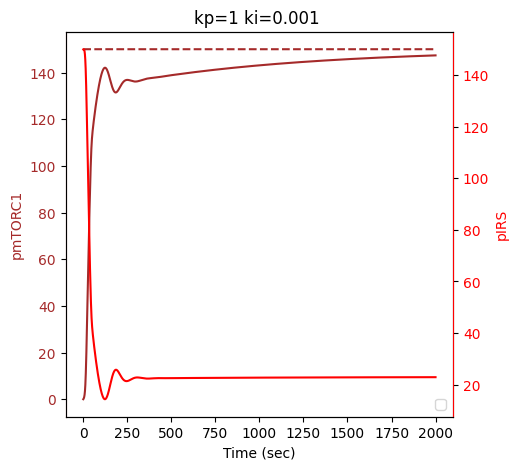

In [16]:
_ = CTLSB.plotClosedLoop(setpoint=150, kp=1, ki=0.001, kf=None, times=np.linspace(0, 2000, 20000))

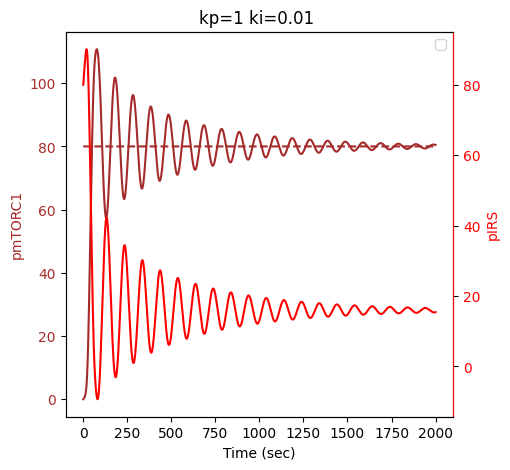

In [17]:
_ = CTLSB.plotClosedLoop(setpoint=80, kp=1, ki=0.01, kf=None)

We are able to simulate the closed loop system, but it's not easy to find design parameters such that: (a) settling times are short; (b) there is not overshoot; and (c) all concentrations are non-negative.

**Notes**
1. Need to use positive feedback. Not clear from the controlability curves.
2. Introducing even a little I behavior makes the controller worse.
3. There is a multimodal behavior of the network that radically changes the long term steady state values. Could this be analyzed by decomposing the system to have multiple tandem controllers. The first controls the effect of IR on pIRS; the second controls the effect of pIRS on pmTORC1.

# Design and Evaluation

100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


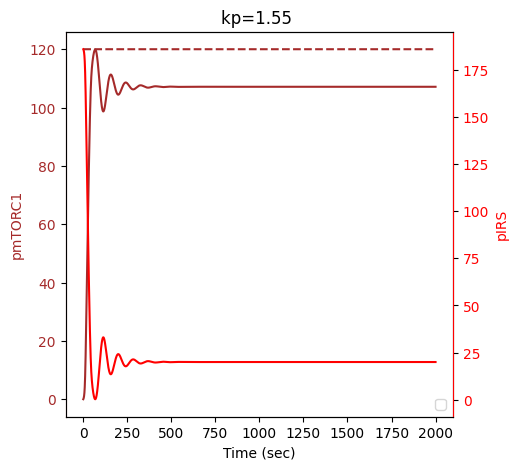

In [18]:
grid = CTLSB.getGrid(kp_spec=True, ki_spec=False, num_coordinate=100, is_random=False)
axis = grid.getAxis("kp")
axis.setMinValue(0.1)
axis.setMaxValue(10)
ts, builder = CTLSB.plotGridDesign(grid, setpoint=120, num_restart=1, is_greedy=False, save_path="data1.csv")

**BUG** Discrepancy with the design plots since there is no value returned for 2.15.

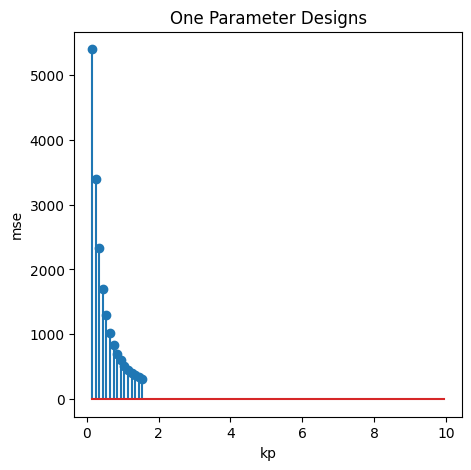

In [19]:
CTLSB.plotDesignResult(figsize=(5,5), title="One Parameter Designs", save_path="data1.csv")

100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


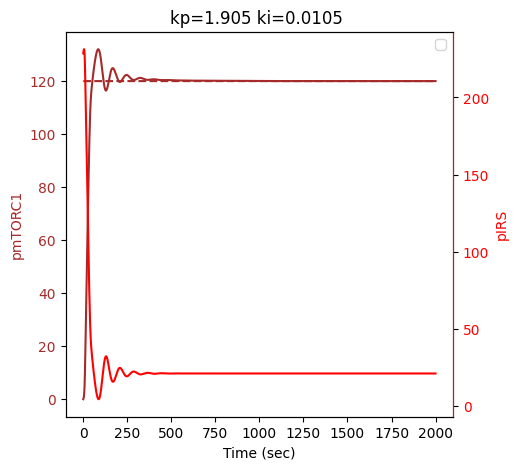

In [20]:
grid = CTLSB.getGrid(kp_spec=True, ki_spec=True, num_coordinate=11, is_random=False)
axis = grid.getAxis("kp")
axis.setMinValue(0.1)
axis.setMaxValue(2)
axis = grid.getAxis("ki")
axis.setMinValue(0.01)
axis.setMaxValue(0.02)
ts, builder = CTLSB.plotGridDesign(grid, setpoint=120, num_restart=1, is_greedy=False, is_report=True, save_path="data2.csv")

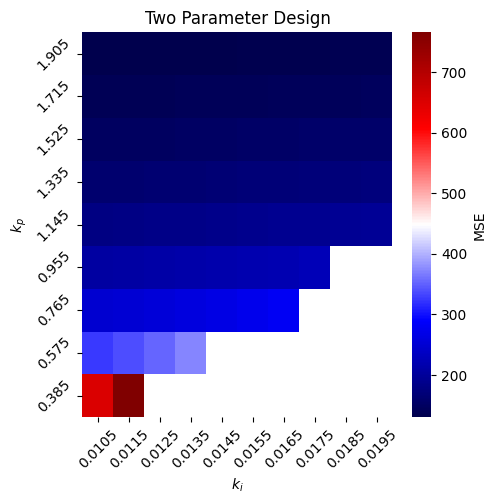

In [21]:
CTLSB.plotDesignResult(figsize=(5,5), save_path="data2.csv", title="Two Parameter Design")

100%|██████████| 1000/1000 [04:24<00:00,  3.79it/s]


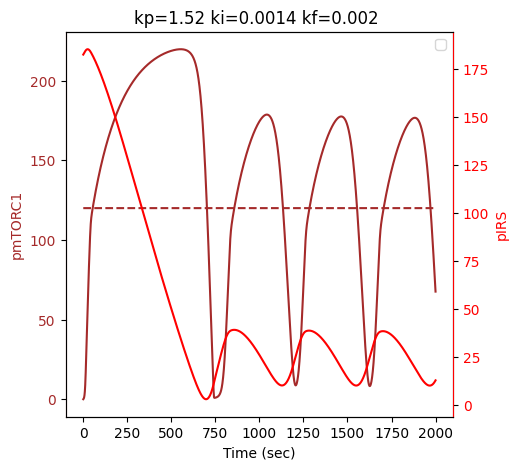

In [22]:
grid = CTLSB.getGrid(kp_spec=True, ki_spec=True, kf_spec=True, num_coordinate=11, is_random=False)
axis = grid.getAxis("kp")
axis.setMinValue(1.5)
axis.setMaxValue(1.9)
axis.setNumCoordinate(11)
axis = grid.getAxis("ki")
axis.setMinValue(0.001)
axis.setMaxValue(0.009)
axis.setNumCoordinate(11)
axis = grid.getAxis("kf")
axis.setMinValue(0.001)
axis.setMaxValue(0.002)
axis.setNumCoordinate(11)
ts, builder = CTLSB.plotGridDesign(grid, setpoint=120, num_restart=1, is_greedy=False, is_report=True, 
                                   save_path="data3.csv")

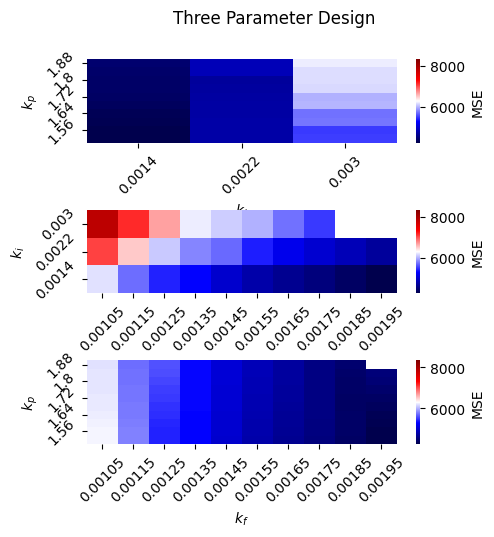

In [23]:
CTLSB.plotDesignResult(figsize=(5,5), save_path="data3.csv", suptitle="Three Parameter Design")

Move x-axis label to far left

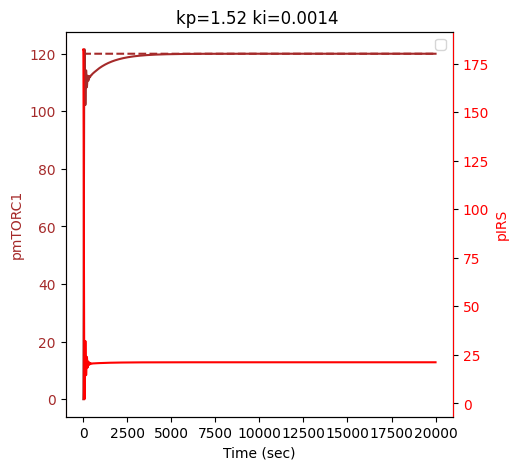

In [24]:
_ = CTLSB.plotClosedLoop(setpoint=120, kp=CTLSB.kp, ki=CTLSB.ki, times=np.linspace(0, 20000, 200000))

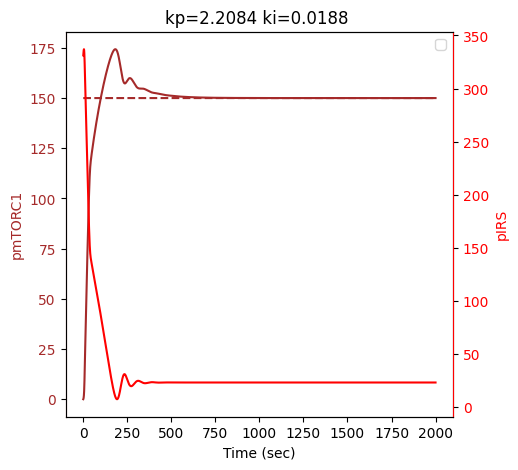

In [25]:
_ = CTLSB.plotClosedLoop(setpoint=150, kp=2.2084, ki=0.0188, times=np.linspace(0, 2000, 20000))

# Issues

1. Handle longer time strings on x-axis